El dataset contiene los registros de transacciones financieras para la detección de fraudes (6,3 millones de registros).

INGRESO EN EFECTIVO: es el proceso de aumentar el saldo de la cuenta mediante un pago en efectivo a un comercio.

RETIRO EN EFECTIVO: es el proceso opuesto al INGRESO EN EFECTIVO; consiste en retirar efectivo de un comercio, lo que disminuye el saldo de la cuenta.

DÉBITO: es un proceso similar al RETIRO EN EFECTIVO e implica enviar el dinero del servicio de dinero móvil a una cuenta bancaria.

PAGO: es el proceso de pagar bienes o servicios a comercios, lo que disminuye el saldo de la cuenta y aumenta el del receptor.

TRANSFERENCIA: es el proceso de enviar dinero a otro usuario del servicio a través de la plataforma de dinero móvil.

In [1]:
from pyspark.sql import SparkSession 
from pyspark.sql.functions import col, sum
from matplotlib import pyplot as plt
import seaborn as sns
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator


In [2]:
spark= SparkSession.builder.appName("fraud").config('spark.master','local[2]').getOrCreate()
df=spark.read.csv("AIML Dataset.csv",header=True,inferSchema=True)
df.show(5)


+----+--------+--------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+
|step|    type|  amount|   nameOrig|oldbalanceOrg|newbalanceOrig|   nameDest|oldbalanceDest|newbalanceDest|isFraud|isFlaggedFraud|
+----+--------+--------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+
|   1| PAYMENT| 9839.64|C1231006815|     170136.0|     160296.36|M1979787155|           0.0|           0.0|      0|             0|
|   1| PAYMENT| 1864.28|C1666544295|      21249.0|      19384.72|M2044282225|           0.0|           0.0|      0|             0|
|   1|TRANSFER|   181.0|C1305486145|        181.0|           0.0| C553264065|           0.0|           0.0|      1|             0|
|   1|CASH_OUT|   181.0| C840083671|        181.0|           0.0|  C38997010|       21182.0|           0.0|      1|             0|
|   1| PAYMENT|11668.14|C2048537720|      41554.0|      29885.86|M1230701703|      

In [3]:
df.printSchema()

root
 |-- step: integer (nullable = true)
 |-- type: string (nullable = true)
 |-- amount: double (nullable = true)
 |-- nameOrig: string (nullable = true)
 |-- oldbalanceOrg: double (nullable = true)
 |-- newbalanceOrig: double (nullable = true)
 |-- nameDest: string (nullable = true)
 |-- oldbalanceDest: double (nullable = true)
 |-- newbalanceDest: double (nullable = true)
 |-- isFraud: integer (nullable = true)
 |-- isFlaggedFraud: integer (nullable = true)



In [4]:
df.describe().show()

+-------+------------------+--------+-----------------+-----------+-----------------+------------------+-----------+------------------+------------------+--------------------+--------------------+
|summary|              step|    type|           amount|   nameOrig|    oldbalanceOrg|    newbalanceOrig|   nameDest|    oldbalanceDest|    newbalanceDest|             isFraud|      isFlaggedFraud|
+-------+------------------+--------+-----------------+-----------+-----------------+------------------+-----------+------------------+------------------+--------------------+--------------------+
|  count|           6362620| 6362620|          6362620|    6362620|          6362620|           6362620|    6362620|           6362620|           6362620|             6362620|             6362620|
|   mean|243.39724563151657|    NULL|179861.9035491287|       NULL|833883.1040744764| 855113.6685785812|       NULL|1100701.6665196533|1224996.3982019224|0.001290820448180152| 2.51468734577894E-6|
| stddev|142.33

In [5]:
dup =df.groupBy('step','type','amount','NameOrig').count().filter('count > 1').show()


+----+----+------+--------+-----+
|step|type|amount|NameOrig|count|
+----+----+------+--------+-----+
+----+----+------+--------+-----+



In [6]:
df.select([sum(col(c).isNull().cast("int")).alias(c) for c in df.columns]).show()

+----+----+------+--------+-------------+--------------+--------+--------------+--------------+-------+--------------+
|step|type|amount|nameOrig|oldbalanceOrg|newbalanceOrig|nameDest|oldbalanceDest|newbalanceDest|isFraud|isFlaggedFraud|
+----+----+------+--------+-------------+--------------+--------+--------------+--------------+-------+--------------+
|   0|   0|     0|       0|            0|             0|       0|             0|             0|      0|             0|
+----+----+------+--------+-------------+--------------+--------+--------------+--------------+-------+--------------+



In [7]:
df.count()

6362620

In [8]:
type_count = df.groupBy('type').count().orderBy('count').toPandas()
type_count.head()

,type,count
0,DEBIT,41432
1,TRANSFER,532909
2,CASH_IN,1399284
3,PAYMENT,2151495
4,CASH_OUT,2237500


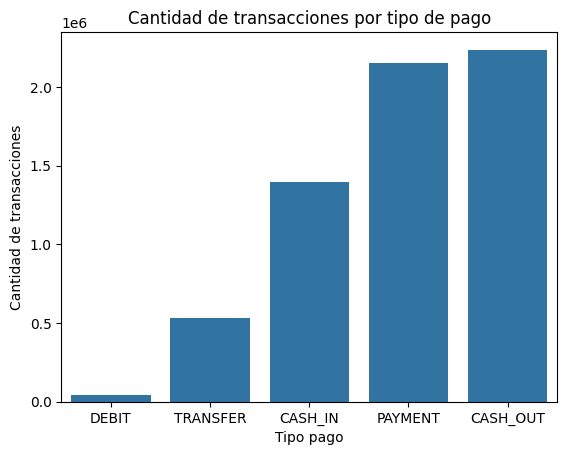

In [9]:

sns.barplot(data=type_count, x='type', y='count')
plt.title('Cantidad de transacciones por tipo de pago')
plt.xlabel('Tipo pago')
plt.ylabel('Cantidad de transacciones')
plt.show()

In [10]:
fraud_count = df.groupBy('isFraud').count().toPandas()
fraud_count.head()

,isFraud,count
0,1,8213
1,0,6354407


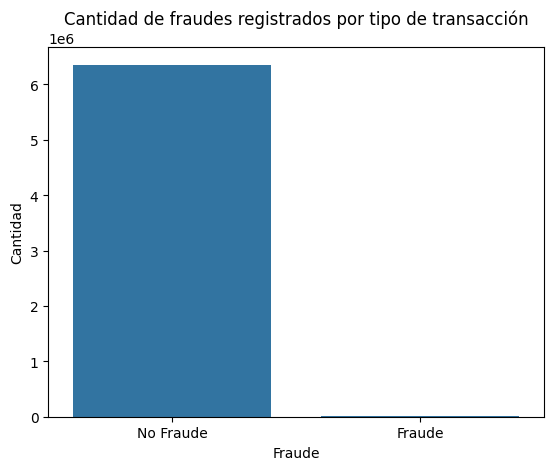

In [11]:
sns.barplot(data=fraud_count,x='isFraud',y='count')
plt.title('Cantidad de fraudes registrados por tipo de transacción')
plt.xlabel('Fraude')
plt.ylabel('Cantidad')
plt.xticks([0,1],['No Fraude','Fraude'])
plt.show()

In [12]:
fraud_by_type = df.groupBy('type','isFraud').agg({'Type':'count'}).toPandas()
fraud_by_type.head()


,type,isFraud,count(Type)
0,PAYMENT,0,2151495
1,CASH_OUT,0,2233384
2,TRANSFER,1,4097
3,CASH_OUT,1,4116
4,DEBIT,0,41432


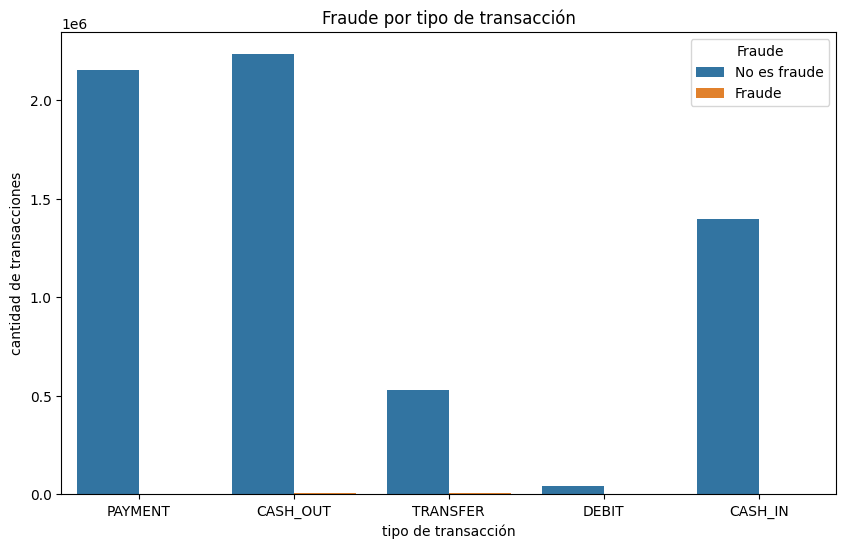

In [13]:
plt.figure(figsize=(10,6))
ax=sns.barplot(data=fraud_by_type,x='type',y='count(Type)',hue='isFraud')
plt.title('Fraude por tipo de transacción')
plt.xlabel('tipo de transacción')
plt.ylabel('cantidad de transacciones')
handles, labels = ax.get_legend_handles_labels()
new_labels = ["No es fraude", "Fraude"]
plt.legend(handles=handles[:], labels=new_labels, title="Fraude")
plt.show()

In [14]:
assembler = VectorAssembler(inputCols=["amount", "oldbalanceOrg", "newbalanceOrig", "oldbalanceDest", "newbalanceDest"], outputCol="features")
train_df, test_df = df.randomSplit([0.8, 0.2], seed=42)

rf = RandomForestClassifier(labelCol="isFraud", featuresCol="features", numTrees=50,seed=42)

pipeline = Pipeline(stages=[assembler, rf])

model = pipeline.fit(train_df)
predictions = model.transform(test_df)

# 5. Evaluar AUC
evaluator = BinaryClassificationEvaluator(labelCol="isFraud", metricName="areaUnderROC")
auc = evaluator.evaluate(predictions)
print(f"AUC: {auc:.4f}")

AUC: 0.9757


In [15]:
spark.stop()